<p style="background-color: #DCDCDC; font-family:calibri; font-size:40px; text-align:center; border-radius:50px 50px;">PREDICTING SOLAR ENERGY PRODUCTION</p>

In [790]:
import pingouin as pg
import datetime as dt
import numpy as np
import pandas as pd
import string
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import scipy
import json
import hashlib
from datetime import datetime
from scipy.stats import boxcox
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, KFold, cross_val_score, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import ipywidgets as widgets
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [588]:
df = pd.read_excel("Solar_Energy_Data.xlsx")

In [590]:
df.head()

,Utility,City/Town,County,Zip,Substation,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Month,Quarter,Year,Age_of_System
0,Con Ed,Richmond Hill,Queens,11418.0,Brownsville_2,Kamtech Solar Solutions,Nm,6.05,5.17,7100,12,4,2023,344
1,Con Ed,Bronx,Bronx,10473.0,Parkchester_2,Kamtech Solar Solutions,Nm,6.74,5.76,7911,12,4,2023,344
2,Con Ed,Brooklyn,Kings,11225.0,Bensonhurst_2,Sunco Project,Nm,3.28,2.80,3845,12,4,2023,344
3,Con Ed,Brooklyn,Kings,11236.0,Bensonhurst_2,Kamtech Solar Solutions,Nm,5.62,4.80,6592,12,4,2023,344
4,Con Ed,Springfield Gardens,Queens,11413.0,Jamaica,Kamtech Solar Solutions,Nm,6.05,5.17,7100,12,4,2023,345


In [592]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101458 entries, 0 to 101457
Data columns (total 14 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Utility                                      101458 non-null  object 
 1   City/Town                                    101458 non-null  object 
 2   County                                       101458 non-null  object 
 3   Zip                                          101458 non-null  float64
 4   Substation                                   101458 non-null  object 
 5   Developer                                    101458 non-null  object 
 6   Metering Method                              101458 non-null  object 
 7   Estimated PV System Size (kWdc)              101458 non-null  float64
 8   PV System Size (kWac)                        101458 non-null  float64
 9   Estimated Annual PV Energy Production (kWh)  101458 non-nul

In [594]:
df['Zip'] = df['Zip'].astype(str)

# <p style="text-align:center; border-radius:50px 50px;">5. FEATURE ENGINEERING</p>

## 5.1 Feature Encoding

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* The dataset consists of different types of features. So we will have to use multiple encoding techniques for the suitable features respectively.
* From the EDA, we observed that 'City/Town', 'Substation', and 'Developer' shows a significant association with the target variable. So we will encode these features using the target encoder. Data leakage is a potential issue with target encoding. To avoid the bias to make sure the model is not generalized well to unseen data, we will perform it after the train-test split.
* 'Zip', 'City/Town', 'County', and 'Substation' are high cardinality features (features that have many unique values and are complex). Feature hashing (Hash Encoder) is suitable for dealing with such features. Since 'Substation' and 'City/Town' will be encoded using Target encoder, we will use Hash encoder only on 'Zip' and 'County'.
* The 'Year' feature is ordinal (it has a natural order), and treating it as a numeric feature is often more appropriate because the order of the years is meaningful. Treating the 'Year' feature as a numeric value maintains the natural order and allows models to interpret the temporal sequence correctly.
* The 'Month' and 'Quarter' features are cyclical. Sine and cosine transformations (Sinusoidal Encoding) are preferable as they preserve the cyclical nature and avoids high-dimensional sparse matrices.
* For the remaining two categorical features with a limited number of unique values like 'Utility' and 'Metering Method', one-hot encoding is an appropriate choice.

### One Hot Encoding

In [597]:
# One hot encoding the nominal columns
nominal_cols = df.columns[[0, 6]]

# Create a OneHotEncoder object
encoder_oh = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical columns
onehot_encoded = encoder_oh.fit_transform(df[nominal_cols])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns=encoder_oh.get_feature_names_out(nominal_cols))

In [599]:
print("Missing values after encoding:", encoded_df.isnull().sum().sum())
print("Duplicates after encoding:", encoded_df.duplicated().sum())

Missing values after encoding: 0
Duplicates after encoding: 101431


In [601]:
encoded_df.head()

,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [603]:
# Columns to drop
df.drop(nominal_cols, axis=1, inplace=True)

In [605]:
# Resetting the indexes before concatenating
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

In [607]:
# Merge DataFrames based on their indexes
data = df.merge(encoded_df, left_index=True, right_index=True)
data.head()

,City/Town,County,Zip,Substation,Developer,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Month,Quarter,Year,Age_of_System,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm
0,Richmond Hill,Queens,11418.0,Brownsville_2,Kamtech Solar Solutions,6.05,5.17,7100,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Bronx,Bronx,10473.0,Parkchester_2,Kamtech Solar Solutions,6.74,5.76,7911,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Brooklyn,Kings,11225.0,Bensonhurst_2,Sunco Project,3.28,2.80,3845,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Brooklyn,Kings,11236.0,Bensonhurst_2,Kamtech Solar Solutions,5.62,4.80,6592,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Springfield Gardens,Queens,11413.0,Jamaica,Kamtech Solar Solutions,6.05,5.17,7100,12,4,2023,345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [609]:
print("Missing values after concatenating:", data.isnull().sum().sum())
print("Duplicates after concatenating:", data.duplicated().sum())

Missing values after concatenating: 0
Duplicates after concatenating: 317


In [611]:
duplicates = data[data.duplicated(keep=False)]
print(duplicates.shape)
duplicates

(607, 25)


,City/Town,County,Zip,Substation,Developer,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Month,Quarter,Year,Age_of_System,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm
49,Bronx,Bronx,10465.0,Parkchester_1,Sunco Project,3.28,2.80,3845,12,4,2023,358,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53,Bronx,Bronx,10465.0,Parkchester_1,Sunco Project,3.28,2.80,3845,12,4,2023,358,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
294,Jamaica,Queens,11434.0,Jamaica,Momentum Solar,3.28,2.80,3845,12,4,2023,346,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295,Jamaica,Queens,11434.0,Jamaica,Momentum Solar,3.28,2.80,3845,12,4,2023,346,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
383,Brooklyn,Kings,11203.0,Bensonhurst_1,Momentum Solar,3.28,2.80,3845,12,4,2023,346,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101411,Dryden,Tompkins,13068.0,NysDryden Tap 524,Atlus Power,18.32,15.66,21507,1,1,2021,1433,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101415,Dryden,Tompkins,13068.0,NysDryden Tap 524,Atlus Power,18.32,15.66,21507,1,1,2021,1433,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101416,Spencerport,Tioga,14883.0,NysVan Etten 570,Atlus Power,18.32,15.66,21507,10,4,2019,1884,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101419,Middlesex,Yates,14544.0,NysRushville 202,Atlus Power,18.32,15.66,21507,12,4,2019,1803,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [613]:
# Identify and drop duplicate rows 
data.drop_duplicates(inplace=True)

In [615]:
data.shape

(101141, 25)

In [617]:
data.head()

,City/Town,County,Zip,Substation,Developer,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Month,Quarter,Year,Age_of_System,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm
0,Richmond Hill,Queens,11418.0,Brownsville_2,Kamtech Solar Solutions,6.05,5.17,7100,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Bronx,Bronx,10473.0,Parkchester_2,Kamtech Solar Solutions,6.74,5.76,7911,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Brooklyn,Kings,11225.0,Bensonhurst_2,Sunco Project,3.28,2.80,3845,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Brooklyn,Kings,11236.0,Bensonhurst_2,Kamtech Solar Solutions,5.62,4.80,6592,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Springfield Gardens,Queens,11413.0,Jamaica,Kamtech Solar Solutions,6.05,5.17,7100,12,4,2023,345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Hash Encoding

In [619]:
def hash_encode(data, column, num_buckets=100):
    data[column] = data[column].astype(str)
    data[column] = data[column].apply(lambda x: hash(x) % num_buckets)
    return data

data = hash_encode(data, 'Zip', num_buckets=100)
data = hash_encode(data, 'County', num_buckets=50)

In [621]:
data.head()

,City/Town,County,Zip,Substation,Developer,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Month,Quarter,Year,Age_of_System,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm
0,Richmond Hill,40,41,Brownsville_2,Kamtech Solar Solutions,6.05,5.17,7100,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Bronx,5,17,Parkchester_2,Kamtech Solar Solutions,6.74,5.76,7911,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Brooklyn,15,96,Bensonhurst_2,Sunco Project,3.28,2.80,3845,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Brooklyn,15,94,Bensonhurst_2,Kamtech Solar Solutions,5.62,4.80,6592,12,4,2023,344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Springfield Gardens,40,59,Jamaica,Kamtech Solar Solutions,6.05,5.17,7100,12,4,2023,345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 5.2 Feature Transformation

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

* When applying transformation or scaling techniques, especially applying transformations like the Box-Cox, it's essential to be wary of data leakage. To avoid data leakage and ensure our model generalizes well to unseen data we will first split our dataset into a training set and a test set and then perform the techniques.
* The Sine and Cosine Transformation (Sinusoidal Encoding) can be done before splitting because they are purely mathematical transformations that do not introduce any external information and only use the values from within the dataset itself.

### Sine & Cosine Transformation (Sinusoidal Encoding)

In [623]:
# Apply Sine and Cosine Transformations to 'Month'
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Apply Sine and Cosine Transformations to 'Quarter'
data['Quarter_sin'] = np.sin(2 * np.pi * data['Quarter'] / 4)
data['Quarter_cos'] = np.cos(2 * np.pi * data['Quarter'] / 4)

# Drop the original 'Month' and 'Quarter' columns
data.drop(columns=['Month', 'Quarter'], inplace=True)

### Train and Test Split

In [625]:
X = data.drop('Estimated Annual PV Energy Production (kWh)', axis=1)
y = data['Estimated Annual PV Energy Production (kWh)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Target Encoding

In [627]:
def target_encode(train, test, target_col, categorical_col):
    # Calculate the mean of the target column grouped by the categorical column
    temp = train.groupby(categorical_col)[target_col].mean()
    
    # Encode the categorical column in the training set
    train[categorical_col + '_encoded'] = train[categorical_col].map(temp)
    
    # Encode the categorical column in the test set
    # If a category in the test set is not found in the training set, assign the global mean of the target column
    test[categorical_col + '_encoded'] = test[categorical_col].map(temp)
    test[categorical_col + '_encoded'].fillna(train[target_col].mean(), inplace=True)
    return train, test

# Apply target encoding to the training set
X_train['Estimated Annual PV Energy Production (kWh)'] = y_train

X_train, X_test = target_encode(X_train, X_test, 'Estimated Annual PV Energy Production (kWh)', 'City/Town')
X_train, X_test = target_encode(X_train, X_test, 'Estimated Annual PV Energy Production (kWh)', 'Substation')
X_train, X_test = target_encode(X_train, X_test, 'Estimated Annual PV Energy Production (kWh)', 'Developer')

# Drop the original target column from training set
X_train.drop('Estimated Annual PV Energy Production (kWh)', axis=1, inplace=True)

# Drop the original categorical columns
X_train.drop(['City/Town', 'Substation', 'Developer'], axis=1, inplace=True)
X_test.drop(['City/Town', 'Substation', 'Developer'], axis=1, inplace=True)

In [629]:
X_test.head()

,County,Zip,Estimated PV System Size (kWdc),PV System Size (kWac),Year,Age_of_System,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm,Month_sin,Month_cos,Quarter_sin,Quarter_cos,City/Town_encoded,Substation_encoded,Developer_encoded
87134,5,19,6.46,5.52,2021,1430,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,11779.546512,12972.612903,10507.188364
36116,1,98,14.04,12.00,2019,2004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.224647e-16,-1.000000,1.224647e-16,-1.000000e+00,13925.717949,12181.506224,11824.105237
9503,40,45,5.43,4.64,2023,675,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.660254e-01,0.500000,1.000000e+00,6.123234e-17,6770.597458,6755.572401,5400.295342
21446,40,95,10.18,8.70,2022,1069,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,7796.297945,6755.572401,7047.012304
53978,2,85,4.45,3.80,2022,725,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000e+00,9128.075949,10493.041113,8432.635621


In [631]:
X_train.head()

,County,Zip,Estimated PV System Size (kWdc),PV System Size (kWac),Year,Age_of_System,Utility_Central Hudson,Utility_Con Ed,Utility_National Grid,Utility_Nyseg,Utility_OR,Utility_Psegli,Utility_Rge,Metering Method_Cdg,Metering Method_Fit,Metering Method_Nm,Metering Method_Rc,Metering Method_Rfp,Metering Method_Rnm,Month_sin,Month_cos,Quarter_sin,Quarter_cos,City/Town_encoded,Substation_encoded,Developer_encoded
2582,1,39,10.88,9.3,2023,417,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-8.660254e-01,0.500000,-2.449294e-16,1.000000e+00,12649.506667,12237.636364,10507.188364
6482,37,32,4.33,3.7,2023,592,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,8431.405649,9361.261653,8432.635621
23678,15,93,6.08,5.2,2021,1237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-5.000000e-01,-0.866025,-1.000000e+00,-1.836970e-16,6983.537061,7633.343023,5400.295342
26206,1,52,11.23,9.6,2021,1412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.000000e-01,0.866025,1.000000e+00,6.123234e-17,10177.769058,10623.053985,10507.188364
88898,44,38,13.34,11.4,2023,358,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000e+00,10759.396429,14896.363636,11774.850575


### Box-Cox Transformation

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

Box-Cox transformation is a powerful method to stabilize variance and make the data more normal-distribution-like. It's particularly useful when you're unsure about the exact nature of the distribution you're dealing with, as it can adapt itself to the best power transformation.

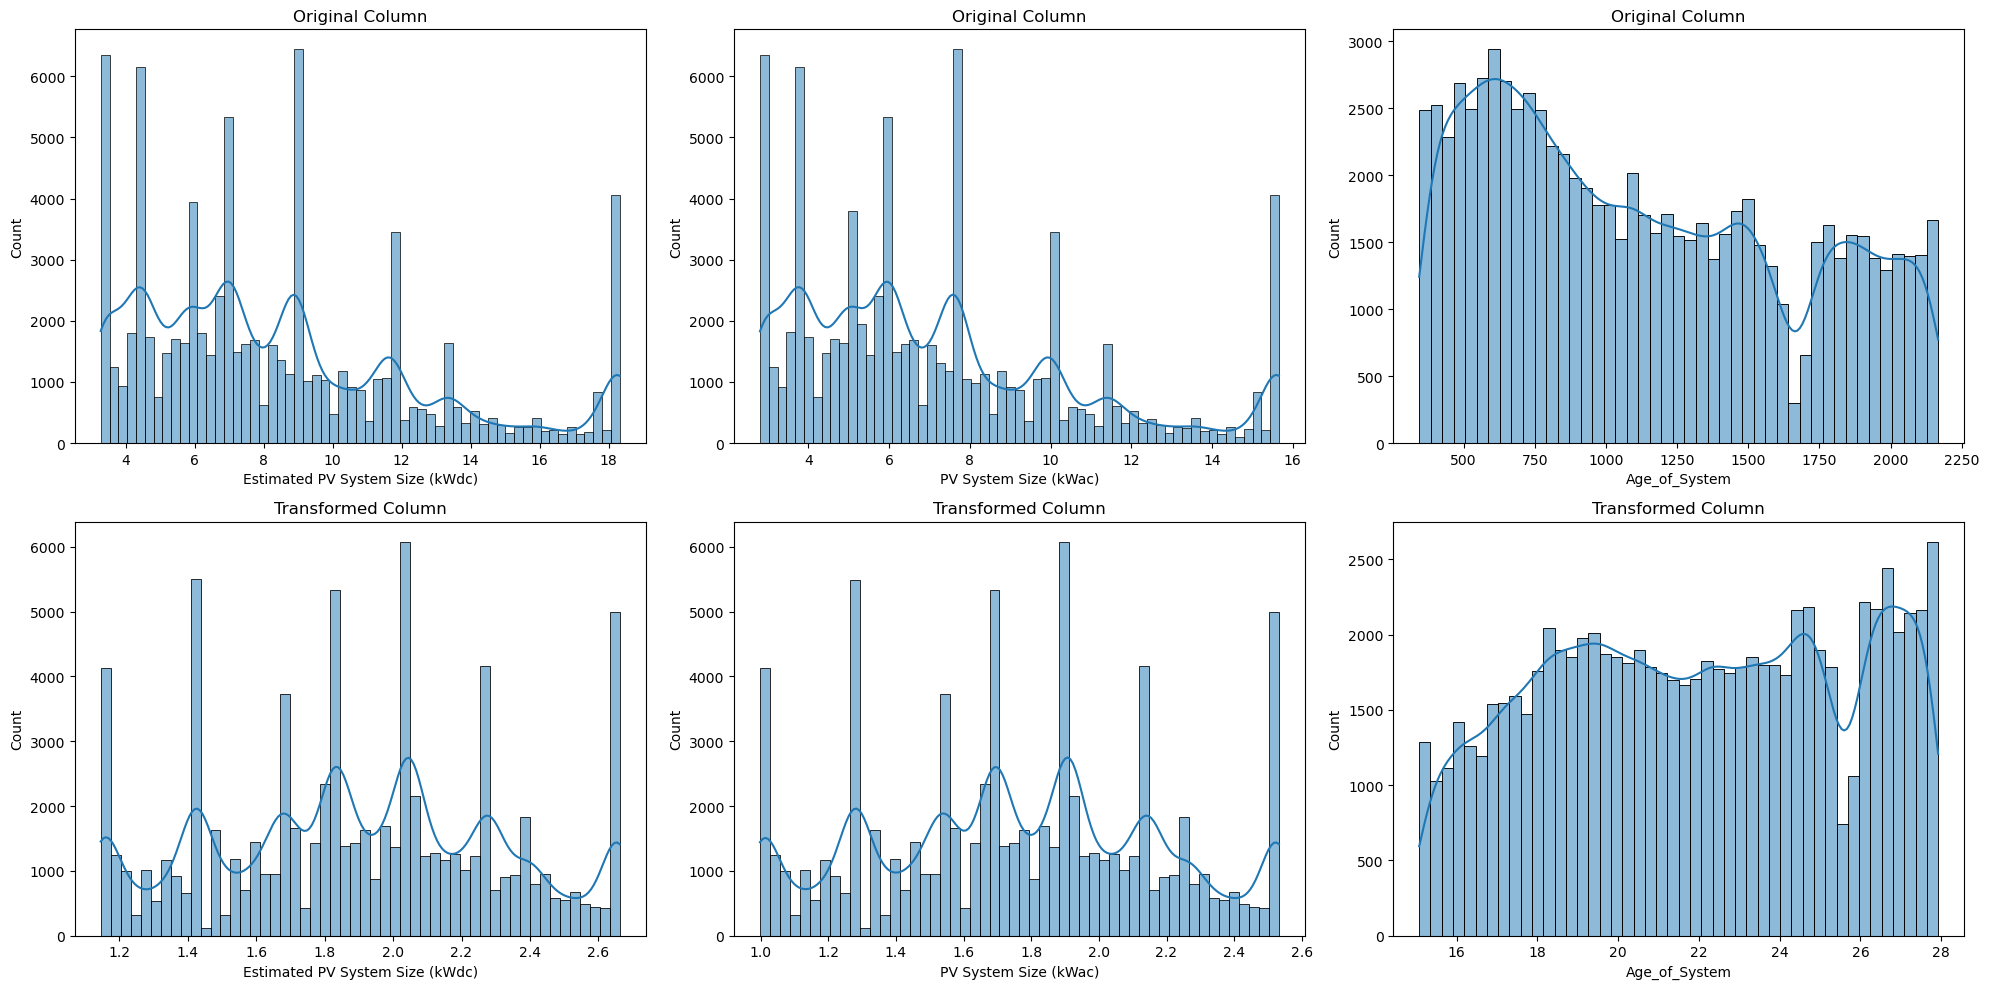

In [633]:
# Defining the numerical columns you want to analyze
num_cols = X_train.iloc[:,[2, 3, 5]] 

# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Original Distributions
for i, col in enumerate(num_cols):
    sns.histplot(X_train[col], kde=True, ax=ax[0, i]).set_title(f'Original Column')

# Applying Box-Cox Transformation
lambdas = {}

# Applying Square Root Transformation
for i, col in enumerate(num_cols):
    # Only applying box cox transformation for positive values
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        # Applying the same lambda to test data
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])  # Use 'lmbda' instead of 'lambda'
        sns.histplot(X_train[col], kde=True, ax=ax[1, i]).set_title(f'Transformed Column')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1, i]).set_title(f'Not Transformed')

plt.tight_layout()
plt.show()

## 4.3 Feature Scaling

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

For the case of predicting solar energy production, RobustScaler might be a good choice. This is because solar energy production data can be influenced by various factors like weather conditions, system efficiency, and maintenance, which can introduce outliers. RobustScaler is more robust to outliers and can provide a more reliable scaling. So we will use RobustScaler for this data.

In [635]:
scaler = RobustScaler()

# Identify the columns to be scaled (excluding 'Year')
cols_to_scale = [col for col in X_train.columns if col != 'Year']

# Fit the scaler to the training data for the selected columns
scaler.fit(X_train[cols_to_scale])

# Transform both training and test data for the selected columns
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [637]:
X_test_scaled.isnull().sum()

County                             0
Zip                                0
Estimated PV System Size (kWdc)    0
PV System Size (kWac)              0
Age_of_System                      0
Utility_Central Hudson             0
Utility_Con Ed                     0
Utility_National Grid              0
Utility_Nyseg                      0
Utility_OR                         0
Utility_Psegli                     0
Utility_Rge                        0
Metering Method_Cdg                0
Metering Method_Fit                0
Metering Method_Nm                 0
Metering Method_Rc                 0
Metering Method_Rfp                0
Metering Method_Rnm                0
Month_sin                          0
Month_cos                          0
Quarter_sin                        0
Quarter_cos                        0
City/Town_encoded                  0
Substation_encoded                 0
Developer_encoded                  0
Year                               0
dtype: int64

In [639]:
X_train_scaled.isnull().sum()

County                             0
Zip                                0
Estimated PV System Size (kWdc)    0
PV System Size (kWac)              0
Age_of_System                      0
Utility_Central Hudson             0
Utility_Con Ed                     0
Utility_National Grid              0
Utility_Nyseg                      0
Utility_OR                         0
Utility_Psegli                     0
Utility_Rge                        0
Metering Method_Cdg                0
Metering Method_Fit                0
Metering Method_Nm                 0
Metering Method_Rc                 0
Metering Method_Rfp                0
Metering Method_Rnm                0
Month_sin                          0
Month_cos                          0
Quarter_sin                        0
Quarter_cos                        0
City/Town_encoded                  0
Substation_encoded                 0
Developer_encoded                  0
Year                               0
dtype: int64

In [641]:
np.any(X_train_scaled < 0)

True

# <p style="text-align:center; border-radius:50px 50px;">6. MODEL BUILDING</p>

## 6.1 Linear Regression

In [654]:
# Instantiate and train the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")
print(f"R2 Score: {r2_score(y_test, y_pred_lr)}")

Linear Regression:
MAE: 972.6534136842979
RMSE: 1214.3904940604425
R2 Score: 0.9347673470124009


In [656]:
def evaluate_regression_model(model, X_test_scaled, y_test, model_name):
    """
    Evaluates the performance of a trained regression model on test data using various metrics.
    
    Parameters:
        model: The trained regression model.
        X_test: Test feature set.
        y_test: Actual target values for the test set.
        model_name: Name of the model (string) for reference.
        
    Returns:
        A DataFrame containing the metrics (MAE, RMSE, R²) for the model.
    """
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store metrics in a dictionary
    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }
    
    # Convert dictionary to DataFrame for comparison
    df = pd.DataFrame(metrics, index=[model_name]).round(4)
    return df

In [720]:
linear_evaluation = evaluate_regression_model(lr, X_test_scaled, y_test, 'Linear Regression')
print(linear_evaluation)

                        MAE       RMSE      R²
Linear Regression  972.6534  1214.3905  0.9348


## 6.2 Ridge Regression

In [668]:
# Define hyperparameter grid
param_grid = {'alpha': [0.1, 1, 10, 100, 200]}

# Grid Search for Ridge
ridge = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train_scaled, y_train)

# Best model and evaluation
ridge_best = grid_search_ridge.best_estimator_
y_pred_ridge = ridge_best.predict(X_test_scaled)
print("Ridge Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ridge)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge))}")
print(f"R2 Score: {r2_score(y_test, y_pred_ridge)}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Ridge Regression:
MAE: 972.5907048803998
RMSE: 1214.296254818842
R2 Score: 0.9347774710001079


In [722]:
ridge_evaluation = evaluate_regression_model(ridge_best, X_test_scaled, y_test, 'Ridge Regression')
print(ridge_evaluation)

                       MAE       RMSE      R²
Ridge Regression  972.5907  1214.2963  0.9348


## 6.3 Lasso Regression

In [674]:
# Define hyperparameter grid
param_grid = {'alpha': [0.01, 0.1, 1, 10]}

# Grid Search for Lasso
lasso = Lasso()
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_lasso.fit(X_train_scaled, y_train)

# Best model and evaluation
lasso_best = grid_search_lasso.best_estimator_
y_pred_lasso = lasso_best.predict(X_test_scaled)
print("Lasso Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso))}")
print(f"R2 Score: {r2_score(y_test, y_pred_lasso)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Lasso Regression:
MAE: 972.5805511475313
RMSE: 1214.109471146689
R2 Score: 0.9347975345825589


In [724]:
lasso_evaluation = evaluate_regression_model(lasso_best, X_test_scaled, y_test, 'Lasso Regression')
print(lasso_evaluation)

                       MAE       RMSE      R²
Lasso Regression  972.5806  1214.1095  0.9348


## 6.4 Decision Tree Regression

In [686]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate model
dt = DecisionTreeRegressor(random_state=42)

# Perform Grid Search
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_dt.fit(X_train_scaled, y_train)

# Best model and evaluation
dt_best = grid_search_dt.best_estimator_
y_pred_dt = dt_best.predict(X_test_scaled)
print("Decision Tree Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_dt)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt))}")
print(f"R2 Score: {r2_score(y_test, y_pred_dt)}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Decision Tree Regression:
MAE: 0.08463097533244353
RMSE: 1.063508102185827
R2 Score: 0.9999999499700661


In [726]:
decision_tree_evaluation = evaluate_regression_model(dt_best, X_test_scaled, y_test, 'Decisison Tree Regression')
print(decision_tree_evaluation)

                              MAE    RMSE   R²
Decisison Tree Regression  0.0846  1.0635  1.0


## 6.5 XGBoost Regression

In [693]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Grid Search for XGBoost
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_xgb.fit(X_train_scaled, y_train)

# Best model and evaluation
xgb_best = grid_search_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test_scaled)
print("XGBoost Regressor:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb)}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBoost Regressor:
MAE: 13.05743166524544
RMSE: 34.283322158514515
R2 Score: 0.9999480106816913


In [728]:
xgboost_evaluation = evaluate_regression_model(xgb_best, X_test_scaled, y_test, 'XGBoost Regression')
print(xgboost_evaluation)

                        MAE     RMSE      R²
XGBoost Regression  13.0574  34.2833  0.9999


## 6.6 LightGBM Regression

In [700]:
# Standardize column names for consistency
X_train.columns = X_train.columns.str.replace(' ', '_').str.lower()
X_test.columns = X_test.columns.str.replace(' ', '_').str.lower()

In [703]:
# Define parameter grid for Random Search
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, -1],  # -1 indicates no limit on depth
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Instantiate LightGBM Regressor
lgb_model = lgb.LGBMRegressor(verbose=-1)

# Randomized Search
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, 
                                       n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search_lgb.fit(X_train_scaled, y_train)

# Best model and evaluation
lgb_best = random_search_lgb.best_estimator_
y_pred_lgb = lgb_best.predict(X_test_scaled)
print("LightGBM Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lgb)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb))}")
print(f"R2 Score: {r2_score(y_test, y_pred_lgb)}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
LightGBM Regression:
MAE: 4.0861997358226345
RMSE: 11.394038762059933
R2 Score: 0.9999942574642364


In [730]:
lightgbm_evaluation = evaluate_regression_model(lgb_best, X_test_scaled, y_test, 'LightGBM Regression')
print(lightgbm_evaluation)

                        MAE    RMSE   R²
LightGBM Regression  4.0862  11.394  1.0


## 6.7 Neural Network Regression

In [751]:
# Define Neural Network Model
def create_nn_model():
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the model
nn_model = create_nn_model()
history = nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

# Evaluate Neural Network
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
print("Neural Network Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_nn)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn))}")
print(f"R2 Score: {r2_score(y_test, y_pred_nn)}")

633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Neural Network Regression:
MAE: 546.3800304868629
RMSE: 640.6230720405936
R2 Score: 0.981846788194122


In [753]:
neural_network_evaluation = evaluate_regression_model(nn_model, X_test_scaled, y_test, 'Neural Network Regression')
print(neural_network_evaluation)

633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                              MAE      RMSE      R²
Neural Network Regression  546.38  640.6231  0.9818


## 6.8 Comparative Analysis

In [800]:
# Concatenate the dataframes
all_evaluations = [linear_evaluation, ridge_evaluation, lasso_evaluation, decision_tree_evaluation, 
                   xgboost_evaluation, lightgbm_evaluation, neural_network_evaluation]
results = pd.concat(all_evaluations)

results = results.sort_values(by='R²', ascending=False).round(6)
results

,MAE,RMSE,R²
Decisison Tree Regression,0.0846,1.0635,1.0000
LightGBM Regression,4.0862,11.3940,1.0000
XGBoost Regression,13.0574,34.2833,0.9999
Neural Network Regression,546.3800,640.6231,0.9818
Linear Regression,972.6534,1214.3905,0.9348
Ridge Regression,972.5907,1214.2963,0.9348
Lasso Regression,972.5806,1214.1095,0.9348


In [802]:
results.to_excel("Evaluation_results.xlsx")

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**OBSERVATIONS:**<br>

**1. Decision Tree Regression:**
* Accuracy: It has shown high accuracy with an R² value of 1.0000, indicating perfect prediction accuracy.
* Interpretability: Decision trees are easy to interpret and visualize, making it easier to understand how the model makes predictions.
* Handling Non-Linearity: Decision trees can capture non-linear relationships in the data.

**2. LightGBM Regression:**
* Performance: LightGBM is known for its high performance and efficiency, especially with large datasets.
* Accuracy: It also has an R² value of 1.0000, indicating excellent prediction accuracy.
* Speed: LightGBM is faster than many other boosting algorithms, making it suitable for large-scale data.

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**STRENGTHS & WEAKNESSES:**<br>

**1. Decision Trees**<br>

i) <u>PROS:<u><br>
* Interpretability: Decision trees are relatively easy to understand and visualize.
* Handles Non-linear Relationships: Can capture complex patterns in the data.
* Robust to Outliers: Less sensitive to outliers compared to linear models.

ii) <u>CONS:<u>
* Overfitting: Can be prone to overfitting, especially with deep trees.
* Instability: Small changes in the data can lead to significant changes in the model.

**2. LightGBM**<br>

i) <u>PROS:<u>
* Efficiency: Faster training and prediction times compared to other gradient boosting algorithms.
* Accuracy: Often achieves high accuracy, especially for large datasets.
* Handles Large Datasets: Can handle large datasets efficiently.
* Handles Missing Values: Can handle missing values without imputation.

ii) <u>CONS:<u>
* Interpretability: Can be less interpretable than decision trees.

<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

**CHOOSING THE BEST MODEL:** <br>

**1. Data Complexity:** <br>
* If the data has complex, non-linear relationships, LightGBM might be a better choice due to its ability to capture intricate patterns.
* For simpler datasets, a decision tree might be sufficient.

**2. Interpretability:** <br>
* If interpretability is a priority, a decision tree might be preferred.
* LightGBM can be made more interpretable by visualizing feature importance.

**3. Computational Resources:** <br>
* LightGBM is generally more efficient than decision trees, especially for large datasets.<br>

**RECOMMENDATION:** <br>
Given the potential complexity of solar energy production data, the project requirements, and the need for accurate predictions, **LightGBM** is a strong contender. It is generally the better choice due to its efficiency and high performance in handling large datasets and complex interactions. It offers a good balance of accuracy and interpretability. Its superior accuracy and speed, combined with its ability to prevent overfitting, makes it an ideal model for predicting solar energy production.

# <p style="text-align:center; border-radius:50px 50px;">7. PREDICTION</p>

## 7.1 Dumping the Model

In [809]:
import joblib
from joblib import dump
dump(lgb_best, 'LightGBM.joblib')

['LightGBM.joblib']

## 7.2 Loading the Model

In [815]:
import gc
gc.collect()

19352